# Previsão de Faturamento - Soma de previsões de produtos modelados individualmente.

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento total mês a mês, somando cada modelo de cada produto

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelos
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Set-up - Acumuladores

In [3]:
arimas = {}
metricas = {}

## Faturamento do produto `alimenticio`

Notebook: [`produto_alimenticio_arima.ipynb`](./produto_alimenticio_arima.ipynb)

In [4]:
analise_produto = 'alimenticio'
fat = tswide['alimenticio'].dropna()

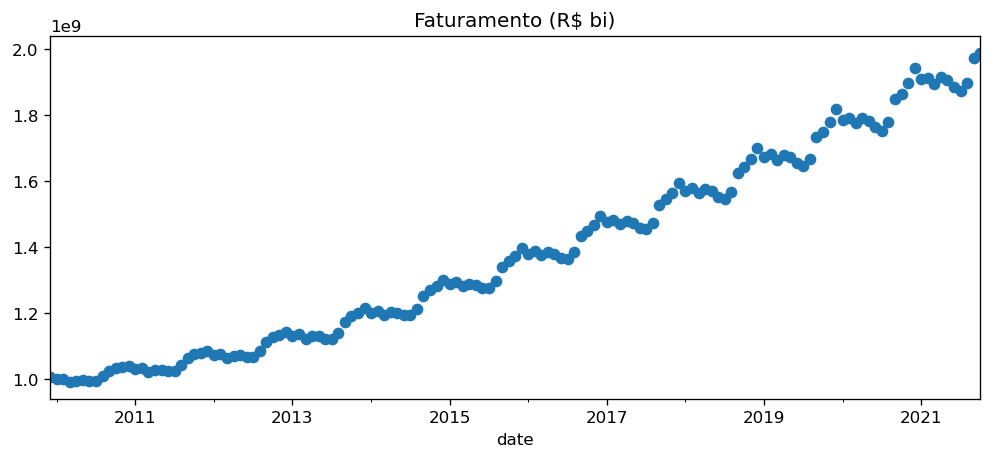

In [5]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

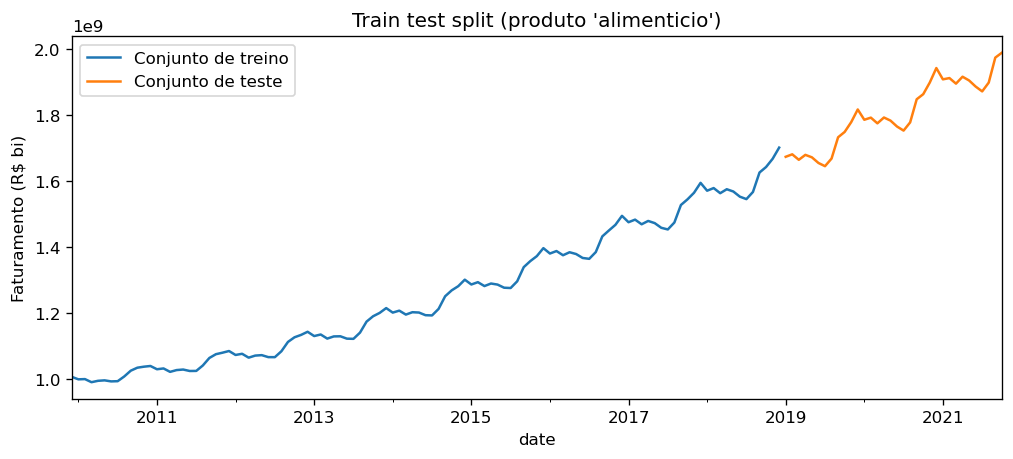

In [6]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

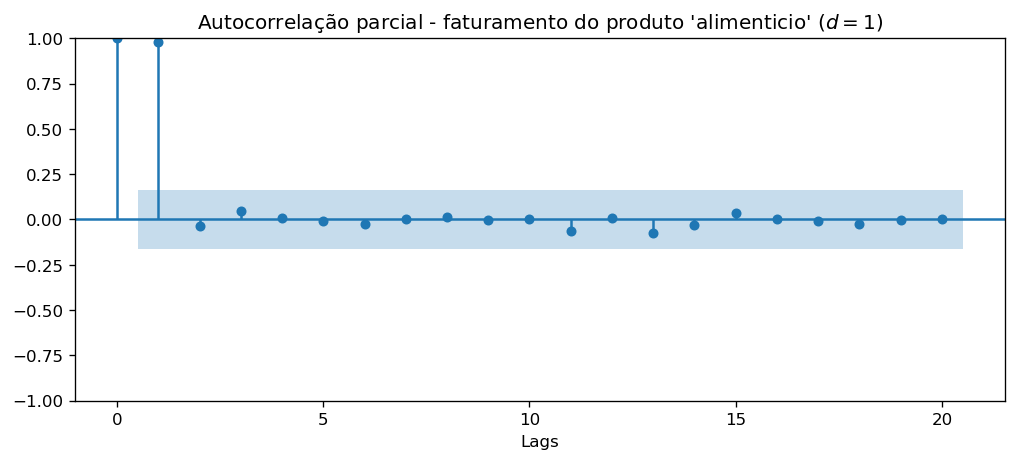

In [7]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d = 1$)")
plt.show()

O melhor ajuste foi obtido em [notebook próprio](./3-faturamento_alimenticio_ts.ipynb):

In [8]:
arimas[analise_produto] = ARIMA(endog = fat_train, order = (0, 1, 0), seasonal_order=(1, 2, 0, 12)).fit()

In [9]:
arimas[analise_produto].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      alimenticio   No. Observations:                  109
Model:             ARIMA(0, 1, 0)x(1, 2, 0, 12)   Log Likelihood               -1245.861
Date:                          Tue, 16 Nov 2021   AIC                           2495.721
Time:                                  20:27:00   BIC                           2500.583
Sample:                              12-01-2009   HQIC                          2497.676
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0014      0.018      0.078      0.938      -0.034       0.037
sigma2      3.818e+11   1.12e-15   3.41e+26      0.000    3.82e+11    3.82e+11
===================================================================================
Ljung-Box (L1) (Q):                  10.10   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               2.09   Skew:                             0.36
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.92e+42. Standard errors may be unstable.
"""

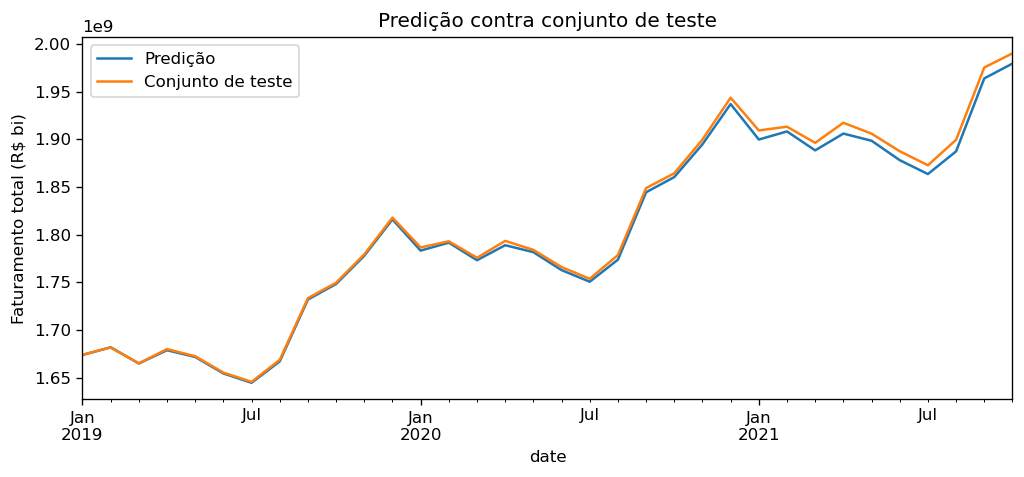

In [10]:
preds = arimas[analise_produto].predict(
    start = fat_test.index.min(),
    end = fat_test.index.max()
)

preds.plot(label = 'Predição')
fat_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

### Métricas

In [11]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds
)

metricas[analise_produto] = dict(
    mape = smape(**kwargs_ajuste),
    rmse = np.sqrt(smse(**kwargs_ajuste)),
    mae = smae(**kwargs_ajuste)
)

mape = metricas[analise_produto]['mape']
rmse = metricas[analise_produto]['rmse']
mae = metricas[analise_produto]['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 0.238%
RMSE: 5.780e+06
 MAE: 4.455e+06
